In [1]:
import csv
import numpy as np # linear algebra
import os
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection  import  train_test_split
from sklearn.model_selection import cross_val_score

import matplotlib
import matplotlib.pyplot as plt

# personal imports
import data_extractor
from encoder_categorical_numerical import Encoder_Categorical_Numerical
import accuracy_extractor

In [2]:
validation = False
index_beginning_actions = 4
upper_limit_seconds = 300
lower_limit_seconds = 5

training_file = "./input/TRAIN.CSV" if not validation else "./input/minitrain.csv"
validation_file = "./input/minitest.csv"
#validation_file
testing_file = "./input/TEST.CSV" if not validation else "./input/minitest.csv"

### Calculer le temps moyen d'une partie

In [3]:
def __ceil_to_five__(seconds):
    """Approximates the number of seconds to the upper multiple of 5.
    :param seconds: number of seconds to approximate
    :return: approxilated seconds
    """
    modulo = seconds % 5
    if modulo == 0:
        return seconds
    else:
        return seconds - modulo + 5

In [4]:
def __remove_tX__(row):
    """Get a new list of words with words of type tX (X a number) removed
    :param myrow: a list of words"""
    tX = re.compile("t\d")
    new_row = []
    for cell in row:
        if tX.match(cell):
            pass
        else:
            new_row.append(cell)
    return new_row

In [5]:
def __get_maximum_time_match__(row, default_time=0):
    """Get the approximate time of a match
    :param myrow: one match"""
    tX = re.compile("t\d")
    for cell in row[::-1]:
        if tX.match(cell):
            return int(cell[1:])
    return default_time

In [6]:
a = ["t5", "a","b","c", "t18","a","b","c", "t150", "a","b"]
__get_maximum_time_match__(a, 0)

150

### Calculer le temps moyen entre deux actions

In [7]:
def __get_speed__(row, max_time):
    tX = re.compile("t\d")
    nb_actions = len(row)
    for cell in row:
        if tX.match(cell):
            nb_actions = nb_actions-1
    return max_time/nb_actions

In [8]:
a = ["t5", "a","b","c", "t18","a","b","c", "t150", "a","b"]
__get_speed__(a, 150)

18.75

### Connaître toutes les actions possibles

In [9]:
def __recognise_possible_actions__(set_of_actions, row):
    for cell in row[index_beginning_actions:]:
        set_of_actions.add(cell)
    return set_of_actions

# Get dataframe

In [10]:
def get_dataframe(path_file, training, upper_limit_seconds, lower_limit_seconds):
    """
    :param path_file:
    :param training: boolean
    :param limit_seconds: int
    :return: A DataFrame with columns named id_player, played_race, 0... n, with n the number of kept actions.
    """
    upper_limit_seconds = __ceil_to_five__(upper_limit_seconds)
    upper_stop_word = "t" + str(upper_limit_seconds)
    lower_limit_seconds = __ceil_to_five__(lower_limit_seconds)
    lower_stop_word = "t" + str(lower_limit_seconds)
    
    extracted = []
    largest_column_count = 0
    possible_actions = set()
    index_new_feature = 2 if training else 1
    lower_column_to_keep = []

    # Loop the data lines
    with open(path_file) as csvfile:
        spamreader = csv.reader(csvfile, delimiter='\n')
        for row in spamreader:
            myrow = row[0].split(',')
            try:
                upper_stop_index = myrow.index(upper_stop_word)
            except:
                upper_stop_index = -1
            try:
                lower_stop_index = myrow.index(lower_stop_word)
            except:
                lower_stop_index = -1
            #compute the time of a match and the average speed between two actions
            time_match = __get_maximum_time_match__(myrow)
            average_speed_match = __get_speed__(myrow, time_match)
            #compute the number of columns to keep for ordered actions
            lower_column_to_keep.append(len(__remove_tX__(myrow[index_new_feature:lower_stop_index]))-1)
            #delete useless tX
            myrow = __remove_tX__(myrow[0:upper_stop_index])
            #know possible set of actions
            possible_actions = __recognise_possible_actions__(possible_actions, myrow)
            #compute the average speed between two actions for a specifical time lapse
            #average_speed_limited_time = __get_speed__(myrow, limit_seconds)
            #insert time_match and average_speed_match as features
            myrow.insert(index_new_feature, time_match)
            myrow.insert(index_new_feature+1, average_speed_match)         
            #myrow.insert(index_time_match+2, average_speed_limited_time)
            #count the number of columns
            largest_column_count = max(len(myrow), largest_column_count)
            extracted.append(myrow)
    column_names = []
    if training:
        column_names = ["id_player", "played_race", "time_match", "average_speed_match"] + [(str(i)+"th_action") for i in range(0, largest_column_count - index_beginning_actions)]
    else:
        column_names = ["played_race", "time_match", "average_speed_match"] + [(str(i)+"th_action") for i in range(0, largest_column_count - index_beginning_actions+1)]
    return pd.DataFrame(extracted, columns = column_names), possible_actions, lower_column_to_keep

In [11]:
df_training, possible_actions_training, lower_column_to_keep_training = get_dataframe(training_file, training=True, upper_limit_seconds=upper_limit_seconds, lower_limit_seconds=lower_limit_seconds)
#df_testing, possible_actions_testing, lower_column_to_keep_testing = get_dataframe(testing_file, training=validation, upper_limit_seconds=upper_limit_seconds, lower_limit_seconds=lower_limit_seconds)
#possible_actions = list(possible_actions_training.union(possible_actions_testing))
possible_actions = possible_actions_training
#index to deleted ordered actions after t
index_column_to_delete = max(lower_column_to_keep_training)+index_beginning_actions+1
#index_column_to_delete = max((max(lower_column_to_keep_training)+index_beginning_actions), (max(lower_column_to_keep_testing)+index_beginning_actions-1))+1

In [12]:
index_column_to_delete

42

In [13]:
df_training.head()
#df_testing.head()

,id_player,played_race,time_match,average_speed_match,0th_action,1th_action,2th_action,3th_action,4th_action,5th_action,...,1786th_action,1787th_action,1788th_action,1789th_action,1790th_action,1791th_action,1792th_action,1793th_action,1794th_action,1795th_action
0,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,1655.0,0.740824,Base,s,s,s,s,s,...,None,None,None,None,None,None,None,None,None,None
1,http://eu.battle.net/sc2/en/profile/3074362/1/...,Protoss,1655.0,0.796056,s,Base,s,s,Base,s,...,None,None,None,None,None,None,None,None,None,None
2,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,1010.0,0.748148,Base,s,s,s,Base,s,...,None,None,None,None,None,None,None,None,None,None
3,http://eu.battle.net/sc2/en/profile/3074362/1/...,Protoss,1005.0,0.723022,Base,s,s,Base,s,s,...,None,None,None,None,None,None,None,None,None,None
4,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,540.0,0.869565,Base,s,s,s,Base,s,...,None,None,None,None,None,None,None,None,None,None


## NOT TO DO: Aligner le nombre de colonnes pour training and testing datasets

In [ ]:
columns_to_add = (set(df_training.columns) - set(df_testing.columns))-set(["id_player"])
for column in columns_to_add: 
    df_testing[column] = np.nan
if validation:
    training_columns_l = len(df_training.columns)-1
    testing_columns_l = len(df_testing.columns)
    if testing_columns_l>training_columns_l:
        columns_to_add = (set(df_testing.columns) - set(df_training.columns))-set(["id_player"])
        for column in columns_to_add: 
            df_training[column] = np.nan

## Last index for ordered_actions

In [14]:
index_end_actions = len(df_training.columns)

In [15]:
index_end_actions

1800

## Calculer l'occurence de chaque action pendant une durée donnée

In [16]:
def __row_of_occurence_actions__(actions, counts, list_of_all_actions):
    dict_of_occurence = {action: 0 for action in list_of_all_actions}
    for action, count in zip(actions, counts):
        dict_of_occurence[action] = count   
    return [int(dict_of_occurence[action]) for action in list_of_all_actions]
        
def __compute_occurence_actions__(df, list_of_all_actions, training=True):
    df_occurence_actions = pd.DataFrame(0, index=df.index, columns=list_of_all_actions, dtype=int)
    for index, row in df.iterrows():
        column_index_start = index_beginning_actions if training else index_beginning_actions-1
        row_to_examine = df.iloc[index,column_index_start:]
        actions, counts = np.unique(row_to_examine.dropna().values, return_counts=True)
        df_occurence_actions.iloc[index,] = __row_of_occurence_actions__(actions, counts, list_of_all_actions)
    return df.join(df_occurence_actions)

In [17]:
df_training = __compute_occurence_actions__(df_training, possible_actions)
#df_testing = __compute_occurence_actions__(df_testing, possible_actions, validation)

In [18]:
df_training.head()

,id_player,played_race,time_match,average_speed_match,0th_action,1th_action,2th_action,3th_action,4th_action,5th_action,...,hotkey40,s,hotkey80,hotkey61,hotkey42,hotkey20,hotkey50,hotkey70,hotkey21,hotkey32
0,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,1655.0,0.740824,Base,s,s,s,s,s,...,1,127,0,0,34,3,1,0,0,147
1,http://eu.battle.net/sc2/en/profile/3074362/1/...,Protoss,1655.0,0.796056,s,Base,s,s,Base,s,...,1,139,1,0,141,4,0,0,0,139
2,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,1010.0,0.748148,Base,s,s,s,Base,s,...,3,158,0,0,27,3,1,0,0,165
3,http://eu.battle.net/sc2/en/profile/3074362/1/...,Protoss,1005.0,0.723022,Base,s,s,Base,s,s,...,1,121,0,0,119,3,0,0,0,115
4,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,540.0,0.869565,Base,s,s,s,Base,s,...,1,138,0,0,34,1,1,0,0,147


## Delete colums to have lower ordered actions

In [19]:
def __delete_columns_for_lower_limit__(df, begin_index, end_index):
    columns_to_delete = list(df.columns[begin_index:end_index])
    return df.drop(columns_to_delete, axis=1)

#### if we want to delete everything as ordonnancy of actions?

In [20]:
df_training = __delete_columns_for_lower_limit__(df_training, index_column_to_delete, index_end_actions)
#df_testing = __delete_columns_for_lower_limit__(df_testing, index_column_to_delete, index_end_actions)
index_end_actions = index_column_to_delete

## Encode values

In [21]:
#Encodage
encoder = Encoder_Categorical_Numerical(df_training, index_beginning_actions, index_end_actions)
df_encoded_training = encoder.encode_df(df_training)
#df_encoded_testing = encoder.encode_df(df_testing, validation)

In [22]:
df_encoded_training.head()
#df_encoded_testing.head()

,id_player,played_race,time_match,average_speed_match,0th_action,1th_action,2th_action,3th_action,4th_action,5th_action,...,hotkey40,s,hotkey80,hotkey61,hotkey42,hotkey20,hotkey50,hotkey70,hotkey21,hotkey32
0,0,3,1655.0,0.740824,19.0,24.0,24.0,24.0,24.0,24.0,...,1,127,0,0,34,3,1,0,0,147
1,1,3,1655.0,0.796056,24.0,19.0,24.0,24.0,19.0,24.0,...,1,139,1,0,141,4,0,0,0,139
2,0,3,1010.0,0.748148,19.0,24.0,24.0,24.0,19.0,24.0,...,3,158,0,0,27,3,1,0,0,165
3,1,3,1005.0,0.723022,19.0,24.0,24.0,19.0,24.0,24.0,...,1,121,0,0,119,3,0,0,0,115
4,0,3,540.0,0.869565,19.0,24.0,24.0,24.0,19.0,24.0,...,1,138,0,0,34,1,1,0,0,147


### For ordered actions, fill with -1 after lower time limit

In [23]:
df_encoded_training = df_encoded_training.fillna(-1)
#df_encoded_testing = df_encoded_testing.fillna(-1)

In [24]:
def __remove_values_to_agree_lower_limit__(df, training, lower_limit_colums, end_index):
    for index_row, begin_index_column in enumerate(lower_limit_colums):
        begin_index_column = begin_index_column + index_beginning_actions
        if training:
            begin_index_column += 1
        df.iloc[index_row, begin_index_column:end_index] = -1
    return df

In [25]:
df_encoded_training = __remove_values_to_agree_lower_limit__(df_encoded_training, True, lower_column_to_keep_training, index_end_actions)
#df_encoded_testing = __remove_values_to_agree_lower_limit__(df_encoded_testing, validation, lower_column_to_keep_testing, index_end_actions)

In [26]:
df_encoded_training.head()
#df_encoded_testing.head()

,id_player,played_race,time_match,average_speed_match,0th_action,1th_action,2th_action,3th_action,4th_action,5th_action,...,hotkey40,s,hotkey80,hotkey61,hotkey42,hotkey20,hotkey50,hotkey70,hotkey21,hotkey32
0,0,3,1655.0,0.740824,19.0,24.0,24.0,24.0,24.0,24.0,...,1,127,0,0,34,3,1,0,0,147
1,1,3,1655.0,0.796056,24.0,19.0,24.0,24.0,19.0,24.0,...,1,139,1,0,141,4,0,0,0,139
2,0,3,1010.0,0.748148,19.0,24.0,24.0,24.0,19.0,24.0,...,3,158,0,0,27,3,1,0,0,165
3,1,3,1005.0,0.723022,19.0,24.0,24.0,19.0,24.0,24.0,...,1,121,0,0,119,3,0,0,0,115
4,0,3,540.0,0.869565,19.0,24.0,24.0,24.0,19.0,24.0,...,1,138,0,0,34,1,1,0,0,147


# delete occurency columns

In [32]:
#index_end_actions
df_encoded_training = __delete_columns_for_lower_limit__(df_encoded_training, index_beginning_actions - 2, len(df_encoded_training.columns))

In [33]:
df_encoded_training.head()

,id_player,played_race
0,0,3
1,1,3
2,0,3
3,1,3
4,0,3


# Selection of model

In [29]:
model = RandomForestClassifier(n_estimators = 64, max_depth = 512)

# Training

In [ ]:
decision_tree.fit(df_encoded_training.iloc[:, 1:].values, df_encoded_training.id_player.values)

# Testing

In [ ]:
predicted = decision_tree.predict(df_encoded_testing.values)
decoded_predicted = encoder.decode_labels(predicted)  # We decode the encoded predictions
indices = range(1, len(predicted) + 1)
output_df = pd.DataFrame({"RowId": indices, "prediction": decoded_predicted})
output_df.to_csv("test_labels.CSV", index=False)

# Small validation

In [ ]:
nolabel_df_validation = df_encoded_testing.drop(axis=1, labels="id_player")
nolabel_df_validation.fillna(0)
predicted = decision_tree.predict(nolabel_df_validation.values)
labels = df_encoded_testing.id_player.values
print("accuracy:", accuracy_extractor.get_accuracy(labels, predicted))

# k-fold cross validation

In [34]:
k = 10
scores = cross_val_score(model, df_encoded_training.iloc[:, 1:].values, y=df_encoded_training.id_player.values, cv=k)
print(scores)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


[0.04010025 0.03926702 0.04189944 0.04297994 0.0477707  0.05136986
 0.05494505 0.06072874 0.06167401 0.06161137]


In [35]:
sum(scores)/10

0.05023463971206878

In [258]:
import matplotlib
import matplotlib.pyplot as plt

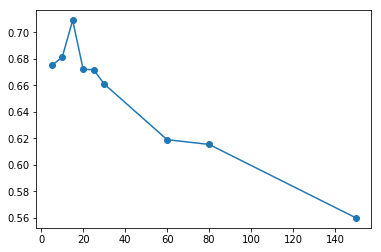

In [226]:
x = [5, 10, 15, 20, 25, 30, 60, 80, 150]
y_scores = [0.675, 0.681, 0.709, 0.6720311962135891, 0.671726521661446, 0.661, 0.619, 0.6154324859571229, 0.5600425108716918]
plt.plot(x, y_scores, marker='o')